In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import dask.array as da

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound
from multiprocessing import Pool

from scipy.optimize import differential_evolution

import psutil
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre
from function import DOWN_raw

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'GSMaP', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'IMERG', '1dy'

yy_s, yy_e = 2002, 2012
years_num = yy_e - yy_s + 1

# Test area
# lon_min, lon_max, lat_min, lat_max = 11, 11.5, 46, 46.5
# Veneto
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'ACF function     : {param['acf']}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : CMORPH_3h.json
ACF function     : str
Number of threads: 25
Neighborhood area: 3x3



In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [6]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## Load Satellite Data

In [6]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,'Satellite',product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,'Satellite',product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1, lat_min-1), lon=slice(lon_min-1, lon_max+1))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1, lat_max+1), lon=slice(lon_min-1, lon_max+1))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data = PRE_data.where(PRE_data >= 0)  # Reemplaza valores negativos con NaN

PRE_1dy = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

PRE_data

Reading data: ERA5_Italy_3h_2000_01_01_2023_12_31.nc


<xarray.Dataset> Size: 52MB
Dimensions:  (time: 32144, lat: 19, lon: 21)
Coordinates:
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
  * lat      (lat) float64 152B 48.0 47.75 47.5 47.25 ... 44.25 44.0 43.75 43.5
  * lon      (lon) float64 168B 9.5 9.75 10.0 10.25 ... 13.75 14.0 14.25 14.5
Data variables:
    PRE      (time, lat, lon) float32 51MB 0.001431 0.001431 ... 0.0 0.0
Attributes:
    description:  ERA5 3 hours data for Italy region

In [7]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    PRE_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lat_ref = PRE_veneto.lat.values
lon_ref = PRE_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

PRE_veneto

<xarray.Dataset> Size: 19MB
Dimensions:  (time: 32144, lat: 11, lon: 13)
Coordinates:
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
  * lat      (lat) float64 88B 47.0 46.75 46.5 46.25 ... 45.25 45.0 44.75 44.5
  * lon      (lon) float64 104B 10.5 10.75 11.0 11.25 ... 12.75 13.0 13.25 13.5
Data variables:
    PRE      (time, lat, lon) float32 18MB 0.04768 0.03386 0.04101 ... 0.0 0.0
Attributes:
    description:  ERA5 3 hours data for Italy region

In [118]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## Compute parameters using functions

In [100]:
## Weibull Parameters - ART
NYs_ART = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])
CYs_ART = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])
WYs_ART = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])

for la in range(len(lat_ref)):
    for lo in range(len(lon_ref)):
        NCWy, _ = DOWN_raw.fit_yearly_weibull(PRE_1dy['PRE'][:,la,lo],1,40)
        NYs_ART[:,la,lo] = NCWy[:,0]
        CYs_ART[:,la,lo] = NCWy[:,1]
        WYs_ART[:,la,lo] = NCWy[:,2]

In [108]:
## Weibull Parameters - ZOR
NYs_ZOR = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])
CYs_ZOR = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])
WYs_ZOR = np.zeros([years_num, len(ndices_lat), len(ndices_lon)])

for la in range(len(lat_ref)):
    for lo in range(len(lon_ref)):

        tsc = PRE_1dy.loc[dict(lat = lats[la], lon = lons[lo])]
        NCWy, YEARSy = DOWN_raw.fit_yearly_weibull(tsc['PRE'], thresh=1, maxmiss=40)

        NYs_ZOR[:,la,lo] = NCWy[:,0]
        CYs_ZOR[:,la,lo] = NCWy[:,1]
        WYs_ZOR[:,la,lo] = NCWy[:,2]

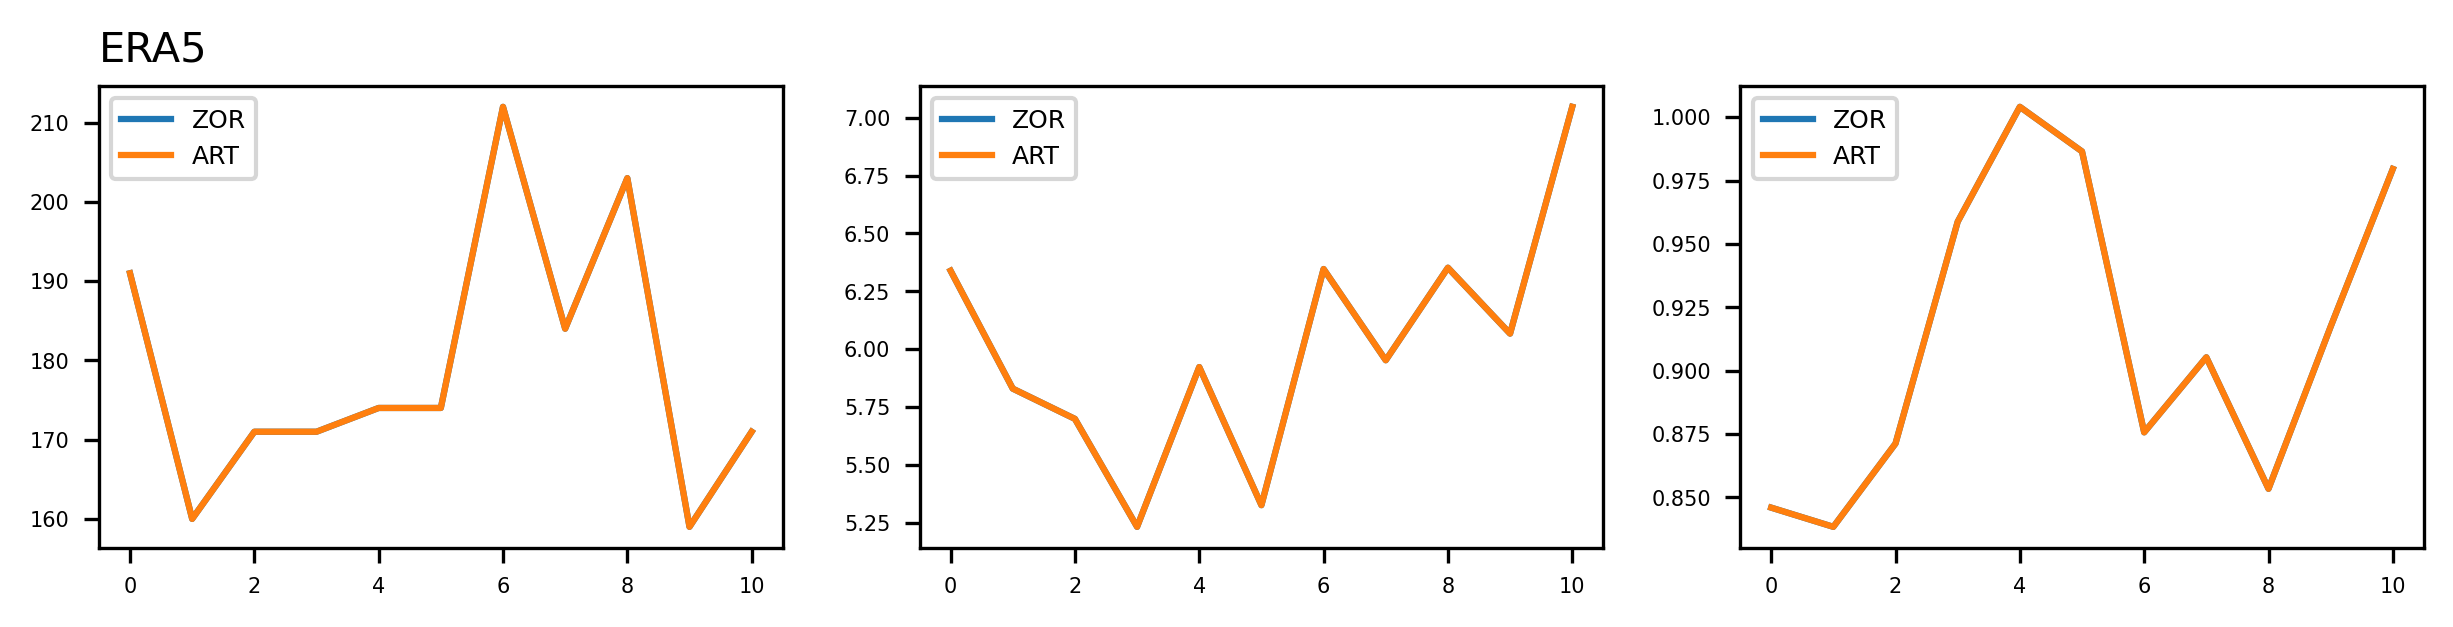

In [109]:
fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(NYs_ZOR[:,6,6], label='ZOR')
ax1.plot(NYs_ART[:,6,6], label='ART')
plt.legend(fontsize=6)

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title(product,fontsize=10,loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(CYs_ZOR[:,6,6], label='ZOR')
ax1.plot(CYs_ART[:,6,6], label='ART')
plt.legend(fontsize=6)

ax1.tick_params(axis='both', which='major', labelsize=5)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.plot(WYs_ZOR[:,1,2], label='ZOR')
ax1.plot(WYs_ART[:,1,2], label='ART')
plt.legend(fontsize=6)

ax1.tick_params(axis='both', which='major', labelsize=5)

In [77]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## Manual Weibull for DOWN_Zorzeto and DOWN_arturo

In [8]:
lat_c = lats[6]
lon_c = lons[6]

In [9]:
print(f'Lat_c: {lat_c}')
print(f'Lon_c: {lon_c}')

Lat_c: 46.5
Lon_c: 11.0


In [10]:
PRE_1dy_T = PRE_1dy.transpose('lon', 'lat', 'time')
x = da.from_array(PRE_1dy_T['PRE'], chunks=(6, 6, 300))
time_vector = PRE_1dy_T['PRE']['time'].values
time_vector_dt = pd.to_datetime(time_vector)
xrs0 = xr.DataArray(x,  coords={'lon':PRE_1dy_T['lon'].values, 'lat':PRE_1dy_T['lat'].values, 'time':time_vector_dt},
                                                    dims=('lon', 'lat', 'time'))

buffer = 0.5*3*0.25

eps = 1e-4
solat = lat_c - buffer + eps
nolat = lat_c + buffer + eps
ealon = lon_c + buffer + eps
welon = lon_c - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs0.lat > solat, xrs0.lat < nolat),
            np.logical_and( xrs0.lon > welon, xrs0.lon < ealon))

box_ZOR = xrs0.where(bcond, drop = True).load()
lon2d_ZOR, lat2d_ZOR = np.meshgrid(box_ZOR['lon'].values, box_ZOR['lat'].values)

print(f'Box Zorzetto: {box_ZOR.shape}')

Box Zorzetto: (3, 3, 4018)


In [11]:
box_ART = ART_pre.create_box_v2(PRE_1dy, lat_c, lon_c, param['npix'])
lon2d_ART, lat2d_ART = np.meshgrid(box_ART['lon'].values, box_ART['lat'].values)
box_ART = box_ART['PRE']

print(f'Box ART: {box_ART.shape}')

Box ART: (4018, 3, 3)


In [12]:
Tr = np.array([5, 10, 20, 50, 100, 200])

In [21]:
downres = DOWN_raw.downscale_only_Weibull(box_ZOR, Tr, thresh=1.0, L0=0.0001, toll=0.005,
                        acf=param['acf'], save_yearly=True,
                        maxmiss=40, clat=lat_c, clon=lon_c,
                        opt_method='genetic', plot=False)

N_ZOR = downres[0][:,0]
C_ZOR = downres[0][:,1]
W_ZOR = downres[0][:,2]
Y_ZOR = downres[1]

Downscaling pdf - yearly Weibull parameters


In [41]:
IMERG_pixel_1dy_xr = xr.DataArray(
            PRE_1dy['PRE'][:,6,6].data, 
            coords={'time':PRE_1dy['time'].values}, 
            dims=('time'))

IMERG_WEIBULL_YEAR = ART_down.fit_yearly_weibull_update(
                    IMERG_pixel_1dy_xr, 
                    thresh=1, 
                    maxmiss=40)

In [50]:
NCWy, _ = DOWN_raw.fit_yearly_weibull(PRE_1dy['PRE'][:,6,6],1,40)
N_ART2 = NCWy[:,0]
C_ART2 = NCWy[:,1]
W_ART2 = NCWy[:,2]

In [43]:
N_ART = IMERG_WEIBULL_YEAR[:,0]
C_ART = IMERG_WEIBULL_YEAR[:,1]
W_ART = IMERG_WEIBULL_YEAR[:,2]
Y_ART = IMERG_WEIBULL_YEAR[:,3]

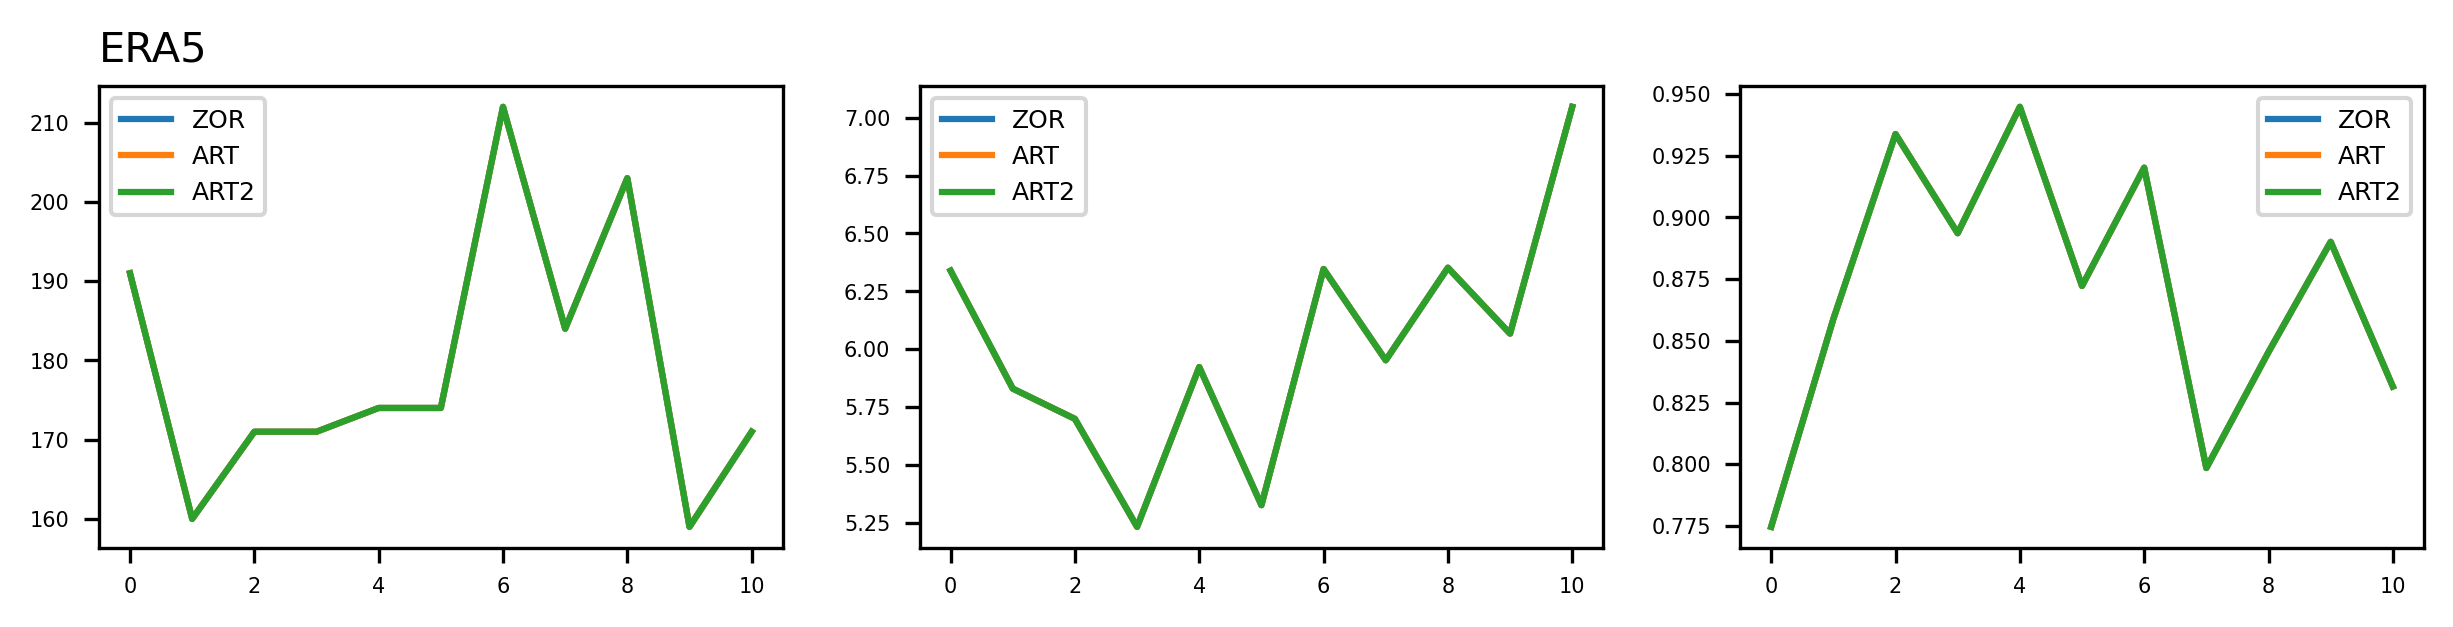

In [78]:
fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(N_ZOR, label='ZOR')
ax1.plot(N_ART, label='ART')
ax1.plot(N_ART2, label='ART2')
plt.legend(fontsize=6)

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title(product,fontsize=10,loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(C_ZOR, label='ZOR')
ax1.plot(C_ART, label='ART')
ax1.plot(C_ART2, label='ART2')
plt.legend(fontsize=6)

ax1.tick_params(axis='both', which='major', labelsize=5)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.plot(W_ZOR, label='ZOR')
ax1.plot(W_ART, label='ART')
ax1.plot(W_ART2, label='ART2')
plt.legend(fontsize=6)

ax1.tick_params(axis='both', which='major', labelsize=5)

In [66]:
# Stop Notebook
sys.exit("🛑 The execution of the cell was stopped")

SystemExit: 🛑 The execution of the cell was stopped

## Compare the results of DOWN_zorzerto and DOWN_arturo

In [19]:
product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'

acf = 'mar'

In [20]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [21]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','4_TEST')

In [22]:
data_dir = os.path.join(dir_base,f'VENETO_DOWN_{product}_3h_2002_2012_npix_1_thr_1_acf_{acf}_ZOR.nc')
DATA = xr.open_dataset(data_dir)

lats = DATA.lat.values
lons = DATA.lon.values

Tr = DATA.Tr.values

NYs_ZOR = DATA.NYs.values
CYs_ZOR = DATA.CYs.values
WYs_ZOR = DATA.WYs.values

MEVs_ZOR = DATA.Mev_s.values
MEVd_ZOR = DATA.Mev_d.values

DATA

FileNotFoundError: [Errno 2] No such file or directory: '/media/arturo/Arturo/Data/Italy/Satellite/4_TEST/VENETO_DOWN_CMORPH_3h_2002_2012_npix_1_thr_1_acf_mar_ZOR.nc'

In [23]:
data_dir = os.path.join(dir_base,f'VENETO_DOWN_{product}_3h_2002_2012_npix_1_thr_1_acf_{acf}_ART.nc')
DATA = xr.open_dataset(data_dir)

NYs_ART = DATA.NYs.values
CYs_ART = DATA.CYs.values
WYs_ART = DATA.WYs.values

MEVs_ART = DATA.Mev_s.values
MEVd_ART = DATA.Mev_d.values

DATA

AttributeError: 'Dataset' object has no attribute 'NYs'

In [12]:
from scipy.stats import pearsonr, spearmanr

def corr_matrix(data1,data2,lat_in,lon_in):
    data_out = np.zeros([len(lat_in),len(lon_in)])
    for la in range(len(lat_in)):
        for lo in range(len(lon_in)):
            corr, _ = pearsonr(data1[:,la,lo], data2[:,la,lo])
            data_out[la,lo] = corr
    
    return data_out

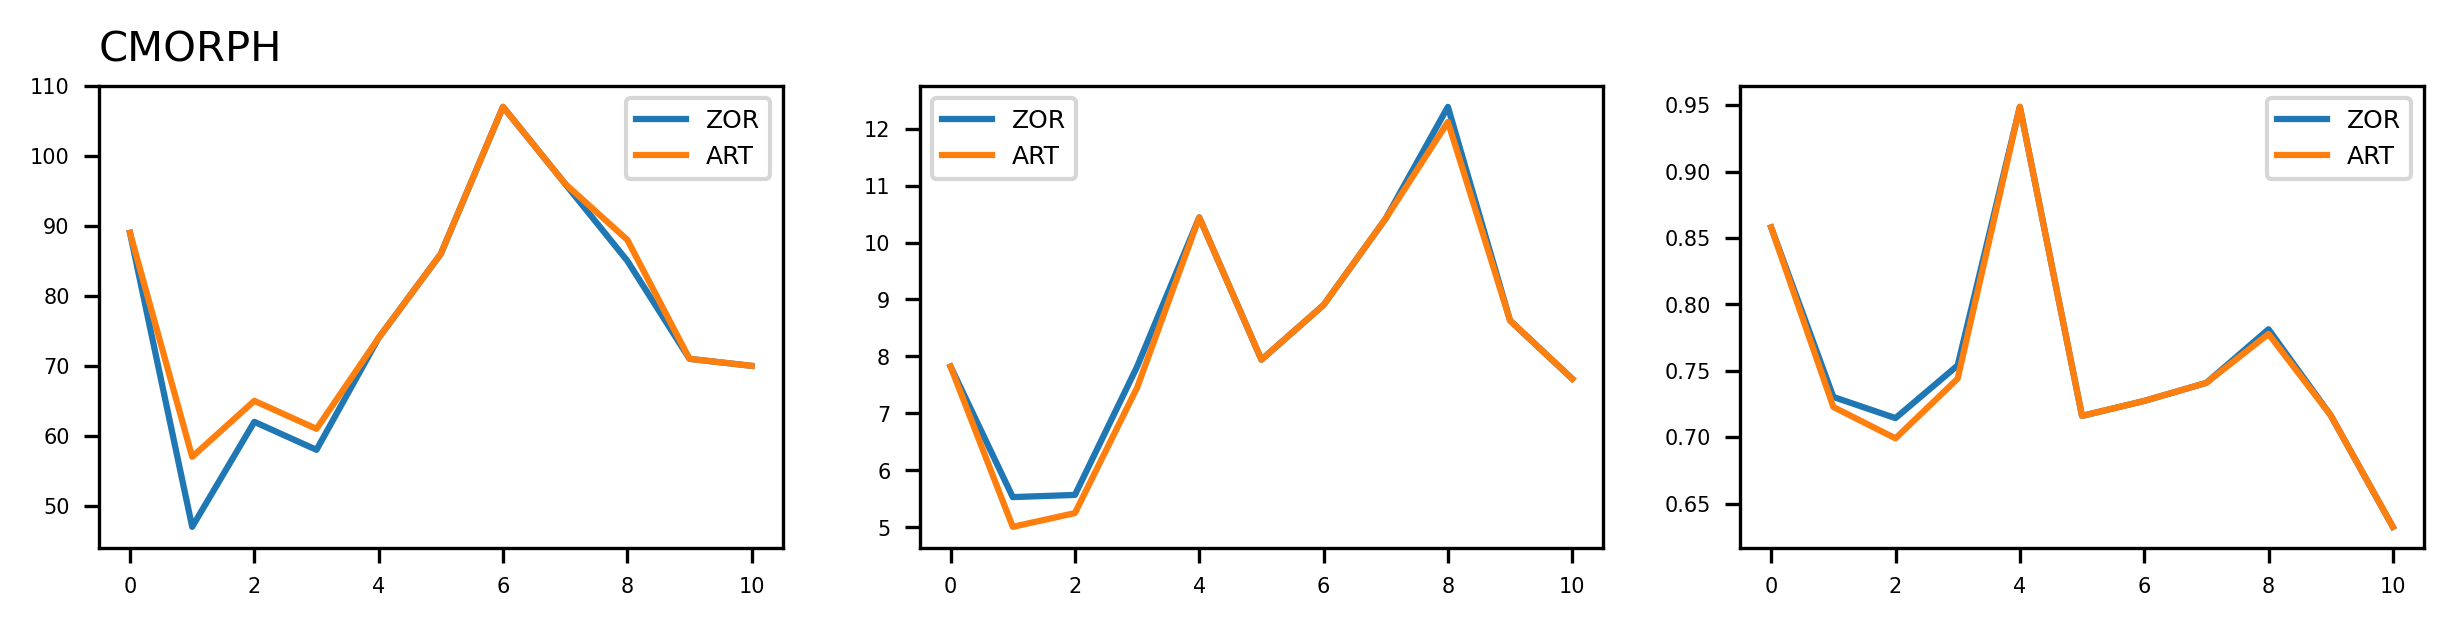

In [13]:
fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(NYs_ZOR[:,2,2], label='ZOR')
ax1.plot(NYs_ART[:,2,2], label='ART')
plt.legend(fontsize=6)

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title(product,fontsize=10,loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(CYs_ZOR[:,2,2], label='ZOR')
ax1.plot(CYs_ART[:,2,2], label='ART')
plt.legend(fontsize=6)

ax1.tick_params(axis='both', which='major', labelsize=5)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.plot(WYs_ZOR[:,2,2], label='ZOR')
ax1.plot(WYs_ART[:,2,2], label='ART')
plt.legend(fontsize=6)

ax1.tick_params(axis='both', which='major', labelsize=5)

In [14]:
NYs_COR = corr_matrix(NYs_ZOR,NYs_ART,lats,lons)
CYs_COR = corr_matrix(CYs_ZOR,CYs_ART,lats,lons)
WYs_COR = corr_matrix(WYs_ZOR,WYs_ART,lats,lons)

In [15]:
np.nanmin(CYs_COR),np.nanmax(CYs_COR)

(np.float64(0.9682749736943895), np.float64(0.9998032449537312))

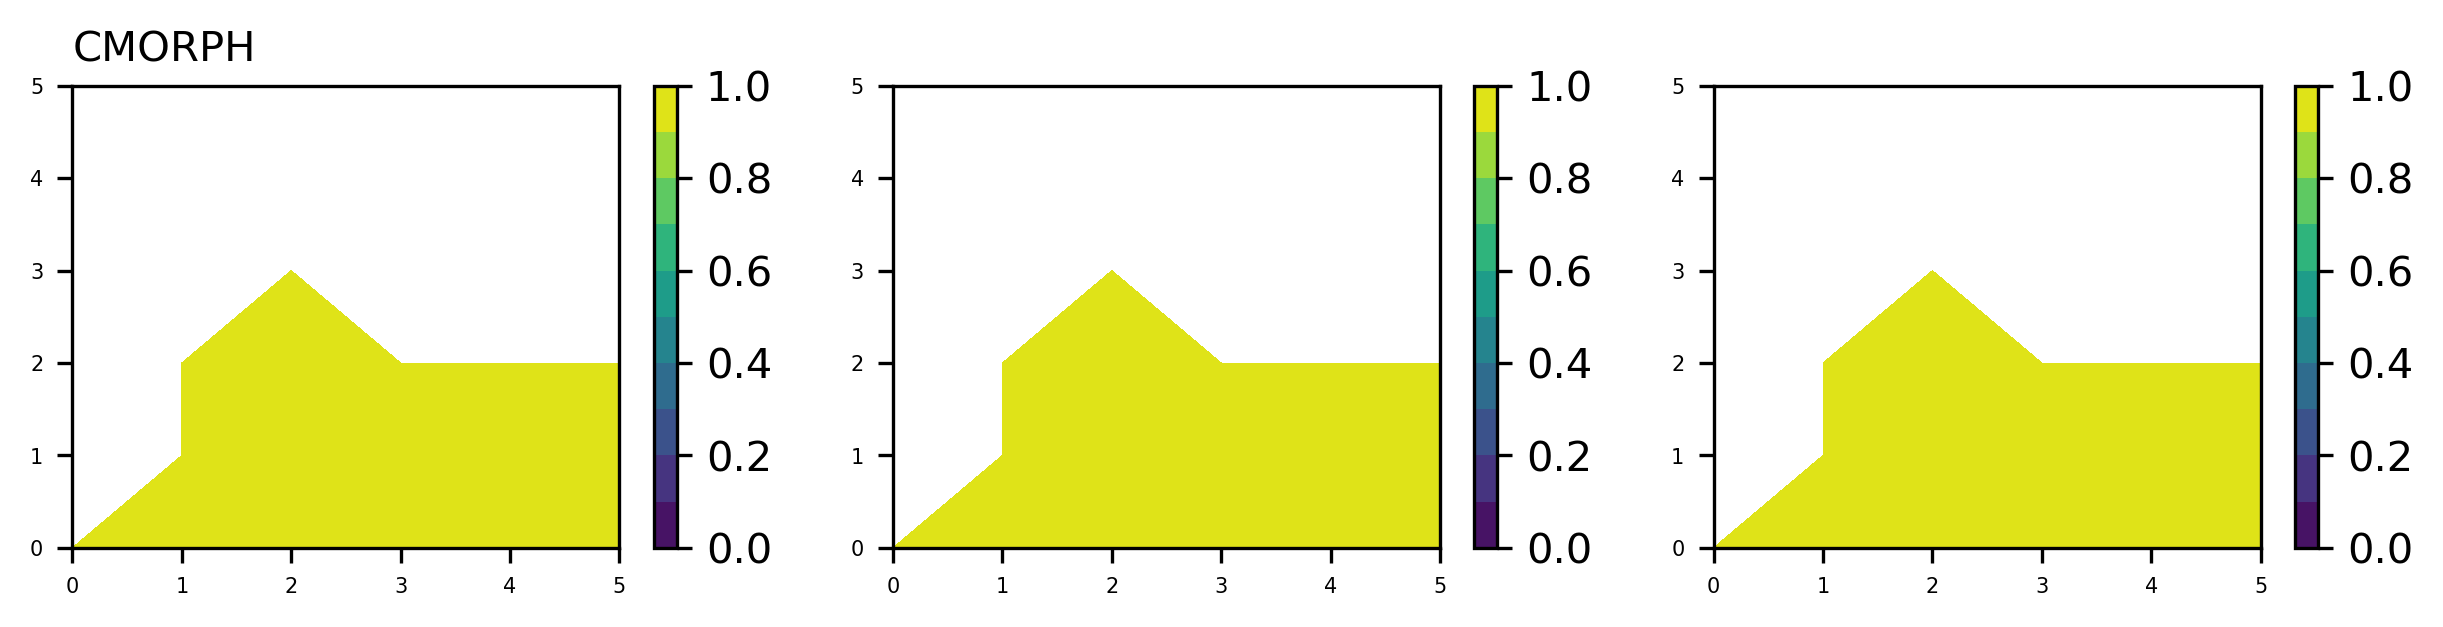

In [16]:
levels = np.arange(0,1.1,0.1)
fig = plt.figure(figsize=(10,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
a1 = ax1.contourf(NYs_COR,levels=levels)
plt.colorbar(a1)

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title(product,fontsize=10,loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
a1 = ax1.contourf(CYs_COR,levels=levels)
plt.colorbar(a1)

ax1.tick_params(axis='both', which='major', labelsize=5)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
a1 = ax1.contourf(WYs_COR,levels=levels)
plt.colorbar(a1)

ax1.tick_params(axis='both', which='major', labelsize=5)

In [17]:
Tr_index = 5
print(f'Return Time: {Tr[Tr_index]} yrs')

Return Time: 200 yrs


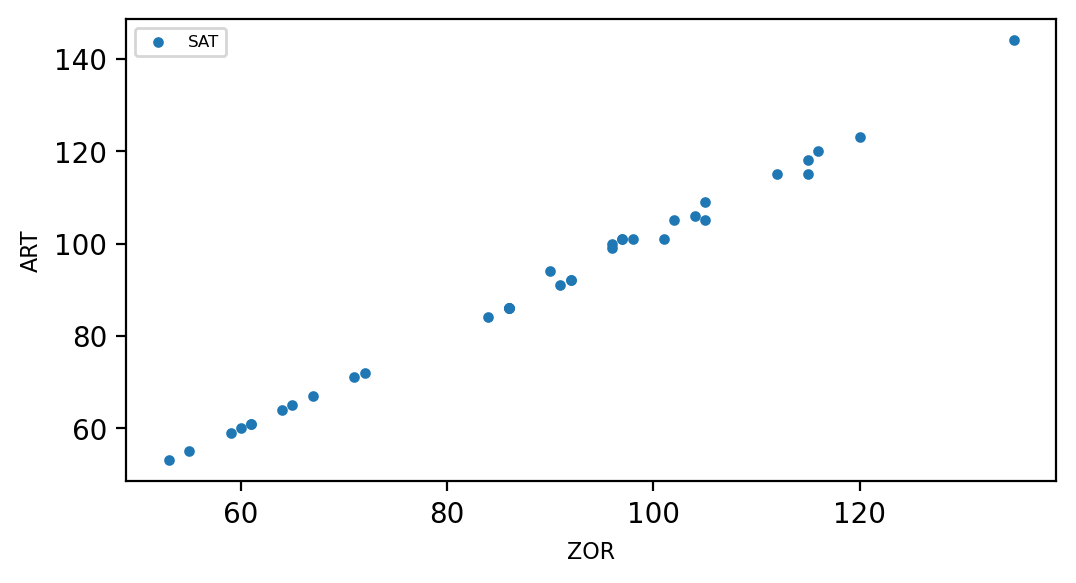

In [18]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# ===================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(NYs_ZOR[Tr_index,:,:].flatten(), NYs_ART[Tr_index,:,:].flatten(),s=8,label='SAT')
# ax1.scatter(MEVd_ZOR[Tr_index,:,:].flatten(), MEVd_ART[Tr_index,:,:].flatten(),s=8,label='DOW')
ax1.set_ylabel('ART',fontsize=8)
ax1.set_xlabel('ZOR',fontsize=8)
plt.legend(fontsize=6)